In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
from tqdm import tqdm
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [4]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
def add_noise(w):
    ret = w + tf.where(tf.math.abs(w) > 0.1, tf.random.normal([len(w)], mean = 0, stddev = tf.math.reduce_std(w)), 0)
    return ret
    
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: add_noise(x[i*stride:i*stride+size]), 
                     tf.repeat(tf.range((length-size)//stride+1), 1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label

In [7]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(100)
    return output_ds

In [8]:
size_sec = 30
stride_sec = 1

In [9]:
train_ds = preprocess_dataset(tf.repeat(train_files, 100))
val_ds = preprocess_dataset(tf.repeat(val_files, 100))
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [10]:
# for spectrogram, y in train_ds.take(1):
#     input_shape = spectrogram.shape
#     print(input_shape)
#     print(y)


In [11]:
input_shape = (30, 257, 1)

In [12]:
batch_size = 256
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [13]:
print('Input shape:', input_shape)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0],input_shape[1])),
    norm_layer,
    
#     layers.LSTM(256, activation='relu', kernel_initializer='he_normal', return_sequences=True),
#     layers.Dropout(0.5),
    layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True),
    layers.Dropout(0.5),
    layers.LSTM(64, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='relu', kernel_initializer='he_normal')
])

model.summary()

Input shape: (30, 257, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 257)           0         
_________________________________________________________________
normalization (Normalization (None, 30, 257)           3         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           197632    
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse',
    metrics='mse'
)

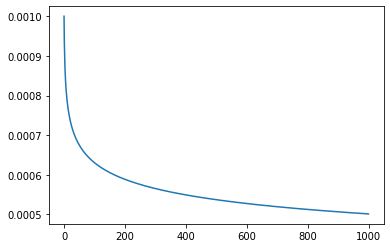

In [15]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.1)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=0.001))
scheduler = SquareRootScheduler(lr=0.001)
plt.plot(tf.range(1000), [scheduler(t) for t in range(1000)])

In [ ]:
EPOCHS = 10000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[lr_callback],
    verbose = 2
)

Epoch 1/10000
30/30 - 78s - loss: 919.9403 - mse: 919.9403 - val_loss: 501.2048 - val_mse: 501.2048
Epoch 2/10000
30/30 - 2s - loss: 568.5717 - mse: 568.5717 - val_loss: 702.1910 - val_mse: 702.1910
Epoch 3/10000
30/30 - 2s - loss: 1065.0068 - mse: 1065.0068 - val_loss: 342.7120 - val_mse: 342.7120
Epoch 4/10000
30/30 - 2s - loss: 379.2697 - mse: 379.2697 - val_loss: 352.2323 - val_mse: 352.2323
Epoch 5/10000
30/30 - 2s - loss: 361.7126 - mse: 361.7126 - val_loss: 307.2768 - val_mse: 307.2768
Epoch 6/10000
30/30 - 2s - loss: 339.3107 - mse: 339.3107 - val_loss: 202.9383 - val_mse: 202.9383
Epoch 7/10000
30/30 - 2s - loss: 1220.1578 - mse: 1220.1578 - val_loss: 316.8748 - val_mse: 316.8748
Epoch 8/10000
30/30 - 2s - loss: 311.8332 - mse: 311.8332 - val_loss: 208.4263 - val_mse: 208.4263
Epoch 9/10000
30/30 - 2s - loss: 287.2213 - mse: 287.2213 - val_loss: 153.7802 - val_mse: 153.7802
Epoch 10/10000
30/30 - 2s - loss: 265.1424 - mse: 265.1424 - val_loss: 185.4435 - val_mse: 185.4435
Epoc

Epoch 84/10000
30/30 - 2s - loss: 87.0200 - mse: 87.0200 - val_loss: 101.6539 - val_mse: 101.6539
Epoch 85/10000
30/30 - 2s - loss: 88.4952 - mse: 88.4952 - val_loss: 106.8169 - val_mse: 106.8169
Epoch 86/10000
30/30 - 2s - loss: 88.0865 - mse: 88.0865 - val_loss: 96.1714 - val_mse: 96.1714
Epoch 87/10000
30/30 - 2s - loss: 89.4167 - mse: 89.4167 - val_loss: 101.2633 - val_mse: 101.2633
Epoch 88/10000
30/30 - 2s - loss: 85.8828 - mse: 85.8828 - val_loss: 89.9316 - val_mse: 89.9316
Epoch 89/10000
30/30 - 2s - loss: 88.5631 - mse: 88.5631 - val_loss: 93.6935 - val_mse: 93.6935
Epoch 90/10000
30/30 - 2s - loss: 85.3827 - mse: 85.3827 - val_loss: 111.6009 - val_mse: 111.6009
Epoch 91/10000
30/30 - 2s - loss: 85.8574 - mse: 85.8574 - val_loss: 97.9367 - val_mse: 97.9367
Epoch 92/10000
30/30 - 2s - loss: 87.5800 - mse: 87.5800 - val_loss: 96.7812 - val_mse: 96.7812
Epoch 93/10000
30/30 - 2s - loss: 85.2861 - mse: 85.2861 - val_loss: 100.9341 - val_mse: 100.9341
Epoch 94/10000
30/30 - 2s - lo

Epoch 168/10000
30/30 - 2s - loss: 68.5339 - mse: 68.5339 - val_loss: 94.6164 - val_mse: 94.6164
Epoch 169/10000
30/30 - 2s - loss: 66.7059 - mse: 66.7059 - val_loss: 91.0433 - val_mse: 91.0433
Epoch 170/10000
30/30 - 2s - loss: 67.8494 - mse: 67.8494 - val_loss: 97.2695 - val_mse: 97.2695
Epoch 171/10000
30/30 - 2s - loss: 66.3238 - mse: 66.3238 - val_loss: 101.0003 - val_mse: 101.0003
Epoch 172/10000
30/30 - 2s - loss: 67.2634 - mse: 67.2634 - val_loss: 96.7364 - val_mse: 96.7364
Epoch 173/10000
30/30 - 2s - loss: 66.5154 - mse: 66.5154 - val_loss: 108.4120 - val_mse: 108.4120
Epoch 174/10000
30/30 - 3s - loss: 66.2292 - mse: 66.2292 - val_loss: 99.2596 - val_mse: 99.2596
Epoch 175/10000
30/30 - 2s - loss: 66.5149 - mse: 66.5149 - val_loss: 103.6086 - val_mse: 103.6086
Epoch 176/10000
30/30 - 2s - loss: 65.7661 - mse: 65.7661 - val_loss: 98.0402 - val_mse: 98.0402
Epoch 177/10000
30/30 - 2s - loss: 69.5416 - mse: 69.5416 - val_loss: 81.9903 - val_mse: 81.9903
Epoch 178/10000
30/30 - 

Epoch 252/10000
30/30 - 2s - loss: 58.8771 - mse: 58.8771 - val_loss: 86.7353 - val_mse: 86.7353
Epoch 253/10000
30/30 - 2s - loss: 64.9242 - mse: 64.9242 - val_loss: 90.1347 - val_mse: 90.1347
Epoch 254/10000
30/30 - 2s - loss: 60.5268 - mse: 60.5268 - val_loss: 96.3861 - val_mse: 96.3861
Epoch 255/10000
30/30 - 2s - loss: 59.8604 - mse: 59.8604 - val_loss: 93.1788 - val_mse: 93.1788
Epoch 256/10000
30/30 - 2s - loss: 60.0307 - mse: 60.0307 - val_loss: 89.8337 - val_mse: 89.8337
Epoch 257/10000
30/30 - 2s - loss: 59.8380 - mse: 59.8380 - val_loss: 89.5480 - val_mse: 89.5480
Epoch 258/10000
30/30 - 2s - loss: 59.9638 - mse: 59.9638 - val_loss: 87.8704 - val_mse: 87.8704
Epoch 259/10000
30/30 - 2s - loss: 57.7833 - mse: 57.7833 - val_loss: 86.0831 - val_mse: 86.0831
Epoch 260/10000
30/30 - 2s - loss: 58.5890 - mse: 58.5890 - val_loss: 83.7250 - val_mse: 83.7250
Epoch 261/10000
30/30 - 2s - loss: 59.5849 - mse: 59.5849 - val_loss: 89.4667 - val_mse: 89.4667
Epoch 262/10000
30/30 - 2s - l

Epoch 336/10000
30/30 - 2s - loss: 54.1826 - mse: 54.1826 - val_loss: 87.2604 - val_mse: 87.2604
Epoch 337/10000
30/30 - 2s - loss: 54.1097 - mse: 54.1097 - val_loss: 91.6554 - val_mse: 91.6554
Epoch 338/10000
30/30 - 2s - loss: 53.8454 - mse: 53.8454 - val_loss: 95.8602 - val_mse: 95.8602
Epoch 339/10000
30/30 - 2s - loss: 54.5269 - mse: 54.5269 - val_loss: 82.8562 - val_mse: 82.8562
Epoch 340/10000
30/30 - 2s - loss: 55.1978 - mse: 55.1978 - val_loss: 85.0027 - val_mse: 85.0027
Epoch 341/10000
30/30 - 2s - loss: 54.7860 - mse: 54.7860 - val_loss: 77.9513 - val_mse: 77.9513
Epoch 342/10000
30/30 - 2s - loss: 53.4841 - mse: 53.4841 - val_loss: 76.4876 - val_mse: 76.4876
Epoch 343/10000
30/30 - 2s - loss: 54.3299 - mse: 54.3299 - val_loss: 89.6779 - val_mse: 89.6779
Epoch 344/10000
30/30 - 2s - loss: 3324726.5000 - mse: 3324726.5000 - val_loss: 88.7890 - val_mse: 88.7890
Epoch 345/10000
30/30 - 3s - loss: 51.7677 - mse: 51.7677 - val_loss: 91.5585 - val_mse: 91.5585
Epoch 346/10000
30/3

Epoch 420/10000
30/30 - 2s - loss: 50.1598 - mse: 50.1598 - val_loss: 96.3687 - val_mse: 96.3687
Epoch 421/10000
30/30 - 2s - loss: 49.5231 - mse: 49.5231 - val_loss: 82.9219 - val_mse: 82.9219
Epoch 422/10000
30/30 - 2s - loss: 49.6954 - mse: 49.6954 - val_loss: 81.3453 - val_mse: 81.3453
Epoch 423/10000
30/30 - 2s - loss: 50.5696 - mse: 50.5696 - val_loss: 91.0305 - val_mse: 91.0305
Epoch 424/10000
30/30 - 2s - loss: 47.9345 - mse: 47.9345 - val_loss: 92.5756 - val_mse: 92.5756
Epoch 425/10000
30/30 - 2s - loss: 49.2713 - mse: 49.2713 - val_loss: 82.4836 - val_mse: 82.4836
Epoch 426/10000
30/30 - 2s - loss: 4059.8342 - mse: 4059.8342 - val_loss: 84.7965 - val_mse: 84.7965
Epoch 427/10000
30/30 - 2s - loss: 49.7116 - mse: 49.7116 - val_loss: 84.0049 - val_mse: 84.0049
Epoch 428/10000
30/30 - 2s - loss: 48.9510 - mse: 48.9510 - val_loss: 80.5281 - val_mse: 80.5281
Epoch 429/10000
30/30 - 2s - loss: 12261.4541 - mse: 12261.4541 - val_loss: 82.5227 - val_mse: 82.5227
Epoch 430/10000
30/3

30/30 - 2s - loss: 45.7272 - mse: 45.7272 - val_loss: 73.6750 - val_mse: 73.6750
Epoch 505/10000
30/30 - 2s - loss: 46.5599 - mse: 46.5599 - val_loss: 82.5374 - val_mse: 82.5374
Epoch 506/10000
30/30 - 2s - loss: 44.8723 - mse: 44.8723 - val_loss: 90.9195 - val_mse: 90.9195
Epoch 507/10000
30/30 - 2s - loss: 45.9945 - mse: 45.9945 - val_loss: 91.3163 - val_mse: 91.3163
Epoch 508/10000
30/30 - 2s - loss: 46.2379 - mse: 46.2379 - val_loss: 95.2116 - val_mse: 95.2116
Epoch 509/10000
30/30 - 2s - loss: 45.1568 - mse: 45.1568 - val_loss: 84.2289 - val_mse: 84.2289
Epoch 510/10000
30/30 - 2s - loss: 45.6628 - mse: 45.6628 - val_loss: 98.5632 - val_mse: 98.5632
Epoch 511/10000
30/30 - 2s - loss: 73.5003 - mse: 73.5003 - val_loss: 83.5030 - val_mse: 83.5030
Epoch 512/10000
30/30 - 2s - loss: 45.3868 - mse: 45.3868 - val_loss: 80.0437 - val_mse: 80.0437
Epoch 513/10000
30/30 - 2s - loss: 66.7086 - mse: 66.7086 - val_loss: 79.4848 - val_mse: 79.4848
Epoch 514/10000
30/30 - 2s - loss: 43.5146 - m

Epoch 589/10000
30/30 - 2s - loss: 41.1820 - mse: 41.1820 - val_loss: 75.4318 - val_mse: 75.4318
Epoch 590/10000
30/30 - 2s - loss: 43.4302 - mse: 43.4302 - val_loss: 79.9822 - val_mse: 79.9822
Epoch 591/10000
30/30 - 2s - loss: 42.8057 - mse: 42.8057 - val_loss: 91.6570 - val_mse: 91.6570
Epoch 592/10000
30/30 - 2s - loss: 41.1364 - mse: 41.1364 - val_loss: 78.7375 - val_mse: 78.7375
Epoch 593/10000
30/30 - 2s - loss: 40.9626 - mse: 40.9626 - val_loss: 88.1025 - val_mse: 88.1025
Epoch 594/10000
30/30 - 2s - loss: 41.3467 - mse: 41.3467 - val_loss: 77.9292 - val_mse: 77.9292
Epoch 595/10000
30/30 - 2s - loss: 41.8762 - mse: 41.8762 - val_loss: 89.7249 - val_mse: 89.7249
Epoch 596/10000
30/30 - 2s - loss: 52.6738 - mse: 52.6738 - val_loss: 76.6811 - val_mse: 76.6811
Epoch 597/10000
30/30 - 2s - loss: 42.4763 - mse: 42.4763 - val_loss: 77.3375 - val_mse: 77.3375
Epoch 598/10000
30/30 - 2s - loss: 41.3742 - mse: 41.3742 - val_loss: 84.7092 - val_mse: 84.7092
Epoch 599/10000
30/30 - 2s - l

In [ ]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
axes = plt.axes()
axes.set_ylim([0, 30])
plt.show()

In [ ]:
np.sqrt(model.evaluate(val_ds.batch(batch_size))) 

In [ ]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

In [ ]:
def window_eval(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data_eval(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
        
    rolling_waveform_tensors = window_eval(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label/30

In [ ]:
# model = tf.keras.models.load_model('saved_model/base_line/20210222')
# model.summary()

In [ ]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data_eval(file)[0]).mean()  
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data_eval(file)[0]).mean() 
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data_eval(file)[0]).mean() 
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [ ]:
meta.predict.describe()

In [ ]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

In [ ]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

In [ ]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

In [ ]:
meta.MMSE.describe()

In [ ]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

In [ ]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
# model.save('saved_model/michael/rl_lstm_wn')

In [ ]:
ls saved_model/michael

# Pitts Corpus

In [ ]:
data_path_pitt = '/tf/data/dementia/English/Pitt/'
files_pitt = tf.io.gfile.glob(data_path_pitt + 'Control/cookie/*.wav') + \
             tf.io.gfile.glob(data_path_pitt + 'Dementia/cookie/*.wav')

In [ ]:
def model_inference(filepath):

    import tensorflow as tf
    import numpy as np
    import json
    import requests	
    import os
    from datetime import datetime
    
    input_file = filepath
    if not filepath.lower().endswith(".wav"):
#         tmp_name = "tmp-"+datetime.now().strftime("%Y%m%d-%H%M%S")
        input_file = input_file.split('.mp3')[0] + '.wav'
        cmd = "ffmpeg -i " + filepath + " " + input_file
        os.system(cmd)
    
    audio_binary = tf.io.read_file(input_file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    if audio.shape[1] > 1:
        audio = tf.reshape(audio[:, 0], (audio.shape[0],1))

    waveform = tf.squeeze(audio, axis=-1)    
    rolling_waveform_tensors = window_eval(waveform, size=_*30, stride=_*1)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
    rolling_spectrograms = rolling_spectrograms.numpy().tolist()
    
    predictions = model.predict(rolling_spectrograms)
    results = [x[0] for x in predictions]
    result = sum(results)/len(results) 

#     os.system('rm ' + input_file)
    return result, results

In [ ]:
meta_pitt = pd.DataFrame(columns= ['file', 'ID', 'Group', 'MMSE', 'predict', 'predict_group', 'predicts'])
for file in tqdm(files_pitt):
#     print(file)
    ID = file.split('/')[-1].split('.')[0]
    Group = file.split('/')[6]
    cha = pd.read_fwf(data_path_pitt + 'Pitt/' + Group + '/cookie/' + ID + '.cha')  
    cha_id = [x for x in cha['@UTF8'] if str.startswith(x, '@ID:')][0]
    
    if (cha_id.split('|')[-3] == ''):
        MMSE = np.NaN
    else:
        MMSE = int(cha_id.split('|')[-3])
        
    predict, predicts = model_inference(file)
    if (predict < 24):
        predict_group = 'Dementia'
    else:
        predict_group = 'Control'
    meta_pitt = meta_pitt.append(pd.DataFrame([[file, ID, Group, MMSE, predict, predict_group, predicts]], 
                                  columns = list(meta_pitt.columns)))

In [ ]:
meta_pitt['predict'] = [x if x < 30 else 30 for x in meta_pitt.predict]
meta_pitt['predict_group'] = ['Control' if x >= 24 else 'Dementia' for x in meta_pitt.predict]

In [ ]:
meta_pitt['predict_min'] = [min(x) for x in meta_pitt.predicts]
meta_pitt['predict_group_min'] = ['Control' if x >= 24 else 'Dementia' for x in meta_pitt.predict_min]

In [ ]:
meta_pitt_eval = meta_pitt[meta_pitt.MMSE.notna()]

In [ ]:
meta_pitt.shape

In [ ]:
meta_pitt_eval.shape

In [ ]:
meta_pitt_eval.head()

In [ ]:
meta_pitt_eval.predict.describe()

In [ ]:
np.sqrt(mean_squared_error(meta_pitt_eval['MMSE'], meta_pitt_eval['predict'] ))

In [ ]:
meta_pitt.to_csv(path_or_buf = '4-RollingWindow+LSTM-pitt.csv', index=True)

In [ ]:
y_true = meta_pitt.Group
y_pred = meta_pitt.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16})# font size

In [ ]:
df_cm

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
ggplot(meta_pitt) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'Group')) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 20, lty = 2)) + \
theme(figure_size = (15, 8))

In [ ]:
# meta_pitt.to_csv(path_or_buf = 'meta_pitt_rollingwindow_lstm.csv', index=True)